In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
def generate_data():
    """Generate synthetic data."""
    # Date range.
    date_range = pd.date_range(start='2017-01-01', end='2020-12-31', freq='D')
    df = pd.DataFrame(data={'date': date_range})
    n = df.shape[0]
    # External regressor.
    df['x'] = np.random.uniform(low=0.0, high=1.0, size=n)
    df['x'] = df['x'].apply(lambda x: x if abs(x) > 0.95 else 0.0)
    # Seasonal variables.
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['daysinmonth'] = df['date'].dt.daysinmonth
    # Construct target variable.
    df['z'] = np.random.normal(loc=0.0, scale=0.5, size=n) \
        + np.power(df.index.values, 1/3) \
        + 2 * np.cos(2*np.pi*df['month']/12) \
        + 0.5 * np.sin(2*np.pi*df['month']/12)\
        + 1.5 * np.cos(2*np.pi*df['day_of_week']/7) \
        + 2 * np.sin(2*np.pi*df['day_of_month']/ df['daysinmonth']) # + 6 * df['x'] + \

    df['y'] = df['z'] + 0.5*df['z'].shift(5) + 0.5*df['z'].shift(15) + 0.3*df['z'].shift(20)
    df.dropna(inplace=True)
    return df

df = generate_data()

df.head()

,date,x,day_of_month,month,day_of_week,daysinmonth,z,y
20,2017-01-21,0.0,21,1,5,31,2.684427,8.538843
21,2017-01-22,0.0,22,1,6,31,3.822030,11.220208
22,2017-01-23,0.0,23,1,0,31,5.132922,11.267334
23,2017-01-24,0.0,24,1,1,31,4.702142,10.724306
24,2017-01-25,0.0,25,1,2,31,1.942953,7.406539


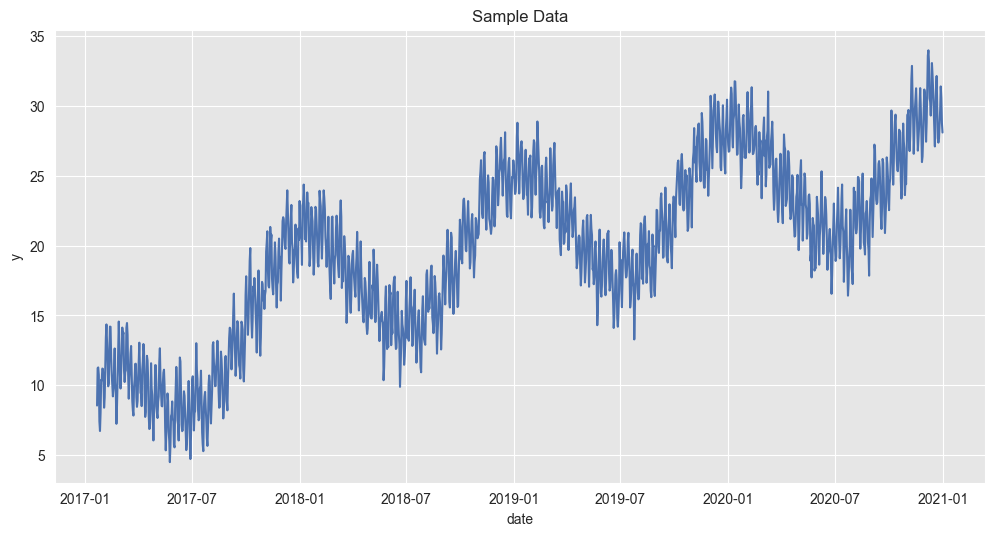

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=df, ax=ax)
ax.set(title='Sample Data');

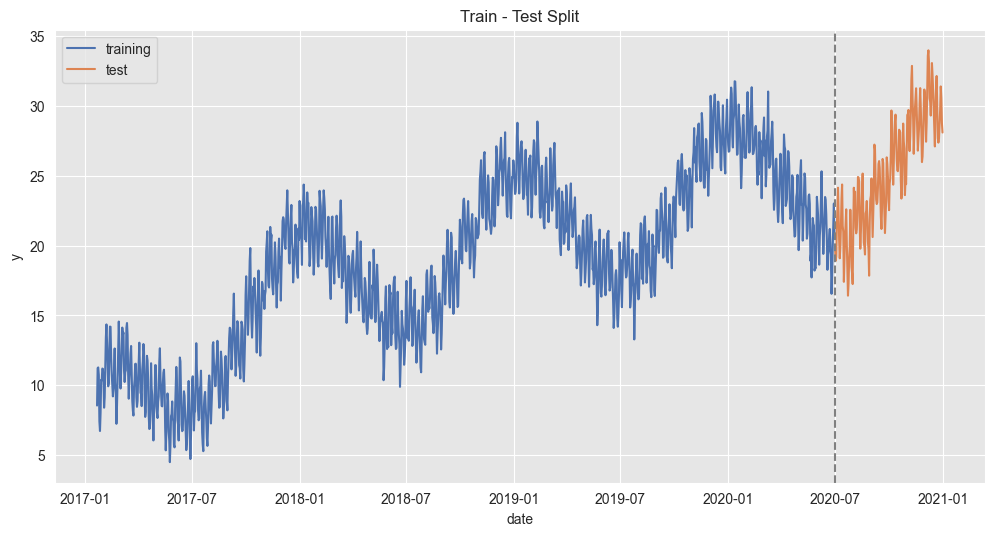

In [4]:
cut_date = '2020-07-01'
df_train = df.query(f'date < "{cut_date}"')
df_test = df.query(f'date >= "{cut_date}"')

fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=df_train, label='training', ax=ax)
sns.lineplot(x='date', y='y', data=df_test, label='test', ax=ax)
ax.axvline(x=cut_date, color='gray', linestyle='--')
ax.legend()
ax.set(title='Train - Test Split');

In [5]:
forecasting_window = 15
training_window = 90

y_train = df_train['y'].to_numpy()
y_train = np.insert(arr=y_train, obj=y_train.shape, values=0)

y_test = df_test['y'].to_numpy()
y_test = np.insert(arr=y_test, obj=y_test.shape, values=0)

In [6]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

y_train_wide = np.concatenate(
    [x for x, _  in TimeseriesGenerator(data=y_train, targets=y_train, length=forecasting_window)]
)

y_test_wide = np.concatenate(
    [x for x, _  in TimeseriesGenerator(data=y_test, targets=y_test, length=forecasting_window)]
)

In [7]:
assert y_train_wide.shape == (y_train.shape[0] - forecasting_window, forecasting_window)
assert y_test_wide.shape == (y_test.shape[0] - forecasting_window, forecasting_window)

In [8]:
# y_train_wide_pad = np.insert(
#     arr=y_train_wide, 
#     obj=0, 
#     values=np.zeros(shape=(training_window, forecasting_window)), 
#     axis=0
# )

# zeros_df = pd.DataFrame(
#     data=np.zeros(shape=(training_window - forecasting_window + 1, df_train.shape[1])), 
#     columns=df_train.columns
# )

# df_train_pad = pd.concat([df_train, zeros_df], axis=0)

# df_train_pad.drop('date', axis=1)

# assert df_train_pad.shape[0] == y_train_wide_pad.shape[0]

In [9]:
features = [
    #'x', 
    'day_of_month',
    'month',
    'day_of_week',
    'y',
]

n_features = len(features)

In [10]:
data_train_gen = TimeseriesGenerator(
    data=df_train[features][: - (forecasting_window - 1)], 
    targets=y_train_wide, 
    length=training_window,
    batch_size=128
)

data_test_gen = TimeseriesGenerator(
    data=df_test[features][: - (forecasting_window - 1)], 
    targets=y_test_wide, 
    length=training_window,
    batch_size=128
)

In [11]:
data_train_gen[0][0].shape

(128, 90, 4)

In [12]:
list(data_train_gen)[0][1][0]

array([ 6.90424763,  8.22108211, 11.56825187,  9.77131874,  9.28607555,
        7.71773609,  6.03681264,  7.99061477,  8.47698991, 11.43326903,
       11.42596689,  9.99201416,  7.99359188,  7.6437644 ,  8.80940562])

In [13]:
pd.DataFrame(list(data_train_gen)[0][0][0])

,0,1,2,3
0,21.0,1.0,5.0,8.538843
1,22.0,1.0,6.0,11.220208
2,23.0,1.0,0.0,11.267334
3,24.0,1.0,1.0,10.724306
4,25.0,1.0,2.0,7.406539
...,...,...,...,...
85,16.0,4.0,6.0,12.100377
86,17.0,4.0,0.0,11.760470
87,18.0,4.0,1.0,10.399282
88,19.0,4.0,2.0,7.835868


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten

model = Sequential([
    LSTM(units=16, activation='relu', input_shape=(training_window, n_features), return_sequences=True),
    LSTM(units=16, activation='relu', return_sequences=False),
    Dense(units=forecasting_window, activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 16)            1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 15)                255       
Total params: 3,711
Trainable params: 3,711
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.losses import MeanAbsoluteError

model.compile(optimizer='adam', loss= MeanAbsoluteError(), metrics=['mse'])

history = model.fit(data_train_gen, epochs=100, validation_data=data_test_gen)

Epoch 1/100
10/10 [==============================] - 3s 149ms/step - loss: 17.9760 - mse: 369.8551 - val_loss: 26.7607 - val_mse: 747.0281
Epoch 2/100
10/10 [==============================] - 1s 52ms/step - loss: 17.0399 - mse: 366.8156 - val_loss: 27.2177 - val_mse: 750.2158
Epoch 3/100
10/10 [==============================] - 1s 50ms/step - loss: 16.7707 - mse: 439.1390 - val_loss: 25.5578 - val_mse: 843.0469
Epoch 4/100
10/10 [==============================] - 1s 51ms/step - loss: 237.4946 - mse: 2222638.4158 - val_loss: 26.4368 - val_mse: 732.1029
Epoch 5/100
10/10 [==============================] - 1s 50ms/step - loss: 19.9586 - mse: 914.0847 - val_loss: 26.0607 - val_mse: 709.7360
Epoch 6/100
10/10 [==============================] - 1s 49ms/step - loss: 25.5333 - mse: 4921.7124 - val_loss: 25.6681 - val_mse: 689.2946
Epoch 7/100
10/10 [==============================] - 1s 51ms/step - loss: 20.6030 - mse: 1379.1772 - val_loss: 24.4385 - val_mse: 644.9336
Epoch 8/100
10/10 [=======

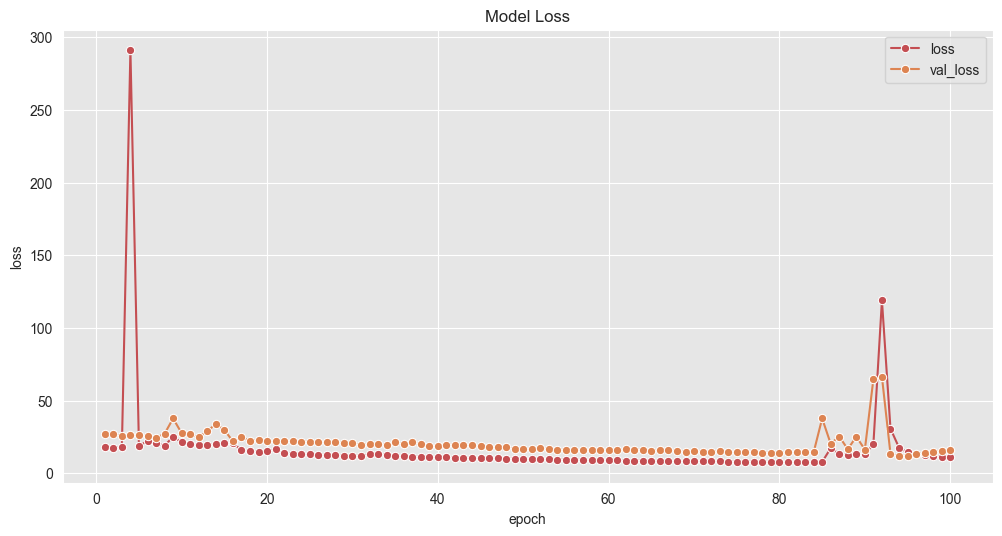

In [16]:
history_df = pd.DataFrame(history.history) \
    .reset_index(drop=False) \
    .eval('epoch = index + 1')

fig, ax = plt.subplots()
sns.lineplot(x='epoch', y='loss', data=history_df, color=sns_c[3], marker='o', label='loss', ax=ax)
sns.lineplot(x='epoch', y='val_loss', data=history_df, color=sns_c[1], marker='o', label='val_loss', ax=ax)
ax.legend(loc='upper right')
ax.set(title='Model Loss');

In [17]:
predictions_train = model.predict(data_train_gen)
predictions_test = model.predict(data_test_gen)

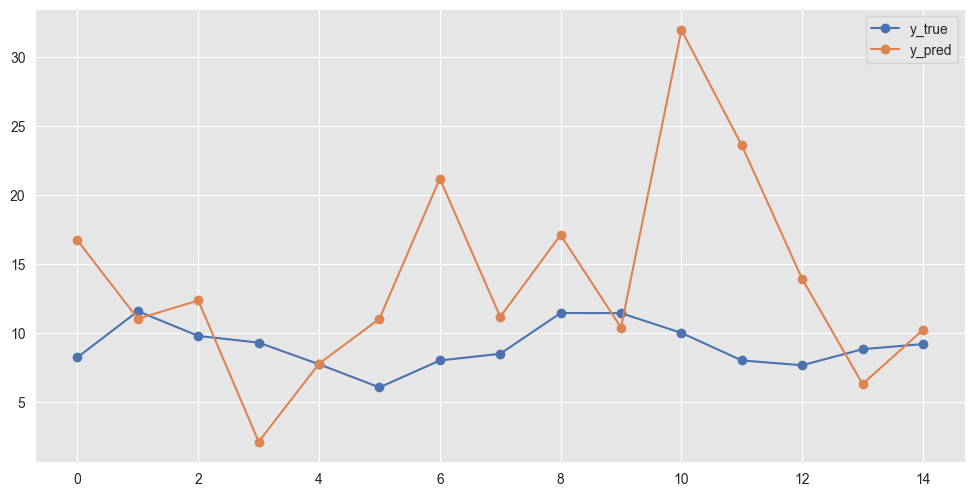

In [18]:
i = 1
fig, ax = plt.subplots()
ax.plot(data_train_gen[0][1][i], marker='o', label='y_true')
ax.plot(predictions_train[i, :], marker='o', label='y_pred')
ax.legend()

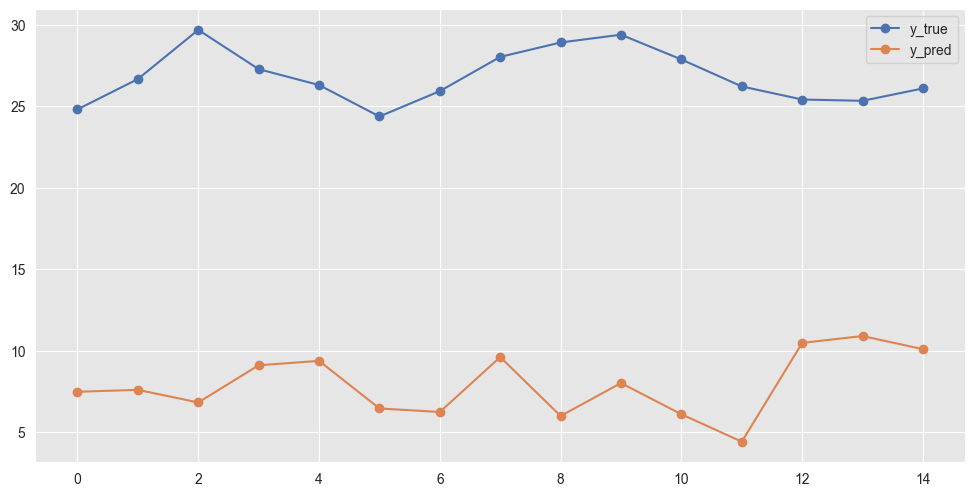

In [19]:
i = 4
fig, ax = plt.subplots()
ax.plot(data_test_gen[0][1][i], marker='o', label='y_true')
ax.plot(predictions_test[i, :], marker='o', label='y_pred')
ax.legend()